# beta-VAE sampling and Laplace evidence calculation (model trained on FMNIST) 

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
import tensorflow_datasets as tfds

In [6]:
PROJECT_PATH  = "./" 
MODULE_PATH   = 'PAE_samples/FMNIST/latent_dim32/VAE/modules'
PARAMS_PATH   = os.path.join(PROJECT_PATH,MODULE_PATH)

param_file    = 'params_fmnist_-1_32_infoGAN_VAE_v2_full_sigma_beta100_C15'
params        = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

params['module_dir'] = os.path.join(PROJECT_PATH,MODULE_PATH)

In [84]:
x_train, _= tfds.as_numpy(tfds.load('fashion_mnist',split='train',batch_size=-1,as_supervised=True,))
x_test, _= tfds.as_numpy(tfds.load('fashion_mnist',split='test',batch_size=-1,as_supervised=True,))

In [80]:
x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)

In [7]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')

In [13]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

def get_posterior(encoder):

    def posterior(x):
        mu, sigma        = tf.split(encoder({'x':x},as_dict=True)['z'], 2, axis=-1)
        sigma            = tf.nn.softplus(sigma) + 1e-6
        approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
        return approx_posterior

    return posterior

In [ ]:
sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)

encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)


likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))
       
prior         = get_prior(params['latent_size'])

In [15]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [16]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood_   = likelihood(z).log_prob(x)
    return likelihood_

def prior_eval(z, prior):
    prior_         = prior.log_prob(z)
    return prior_

def posterior_eval(z,x,likelihood, prior):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(z,x,likelihood)
    prior_       = prior_eval(z, prior)
    logprob      = likelihood_+prior_
    return logprob


class LogP():
    def __init__(self,x):
        self.x = x
        self.z_fill = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)
    
    def logp_grad(self,z):

        self.z_fill.assign(z)
        z_  = tf.convert_to_tensor(self.z_fill)
        
        with tf.GradientTape() as tape:
            tape.watch(z_)
            log_p         = posterior_eval(z_,self.x,likelihood, prior)
        grad = tape.gradient(log_p, [z_])
        return log_p, grad[0]

    @tf.custom_gradient
    def logp(self,z):

        logp, grads = self.logp_grad(z)

        def grad(up,variables=None):
            grad_ = tf.expand_dims(up,-1)*grads

            return grad_, [None for ii in range(len(variables))] 

        return logp, grad

### example for how to evaluate log[p(x,z)]

In [16]:
x     = x_test[0:params['batch_size']]# or np.repeat(x_test[0:1], params['batch_size'], axis=0)
LP    = LogP(x)
# mean of approximate posterior
z_ini = get_encoded(x)

In [17]:
# mean and variance of approximate posterior
encoded, sigma_encoded = tf.split(encoder({'x':x})['z'], 2, axis=-1)
sigma_encoded = tf.nn.softplus(sigma_encoded[0]) + 1e-6

### Example for how to evaluate gradient of log p

In [20]:
z_ = tf.constant(z_ini)
with tf.GradientTape() as g:
    g.watch(z_)
    y = LP.logp(z_)
grad = g.gradient(y, z_)
print(grad)

tf.Tensor(
[[-2.3426995   1.6581117  -0.9153836  ... -0.19065689 -0.20767261
  -1.1782926 ]
 [-1.666039   -1.3340384   1.1130762  ...  0.07000353 -1.099867
   0.3085489 ]
 [-0.20543237  0.08611883 -0.40272793 ... -0.1498641  -0.10076399
   0.48625675]
 ...
 [-0.22219251  0.58801347 -0.1375675  ... -0.15719311  0.11488966
   0.6741675 ]
 [-6.138344    2.5686312  -3.060173   ... -0.5490912   4.0049033
  -1.2811694 ]
 [-0.39654133  1.5291479  -1.0410328  ...  2.9116535   0.17329425
  -0.10858858]], shape=(128, 32), dtype=float32)


### loading MAPs for first 128 test images and the Hessians at the MAP

In [8]:
#load them here or generate them below
filename = os.path.join(PROJECT_PATH, 'PAE_samples/FMNIST/latent_dim32/VAE/samples','MAP_xtest0-128.npy')
z_min    = np.load(filename)

filename = os.path.join(PROJECT_PATH, 'PAE_samples/FMNIST/latent_dim32/VAE/samples','Hessians_xtest0-128.npy')
h        = np.load(filename)

### Find true minimum of posterior with optimization

In [17]:
optimizer  = tf.keras.optimizers.Adam(learning_rate=0.01)
z_res      = []
losses     = []

x     = x_test[0:params['batch_size']]#np.repeat(, params['batch_size'], axis=0)##
LP    = LogP(x)
z_ini = get_encoded(x)

z_var     = tf.Variable(z_ini)
for iteration in tqdm(range(1000)):
    optimizer.minimize(lambda: -tf.reduce_sum(LP.logp(z_var)), var_list=[z_var])
    loss  = -LP.logp(z_var)
    losses.append(loss)


100%|██████████| 1000/1000 [00:45<00:00, 22.11it/s]


In [18]:
losses = np.asarray(losses)

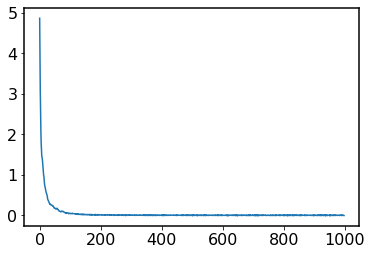

In [23]:
plt.plot(np.diff(-np.mean(losses,axis=1)))
plt.show()

### Example for how to evaluate the Hessian

In [ ]:
z_min = tf.convert_to_tensor(z_var)
z_    = tf.convert_to_tensor(z_min)

with tf.GradientTape(persistent=True) as t1:
    t1.watch(z_)
    y    = posterior_eval(z_,LP.x,likelihood, prior)
    g    = t1.gradient(y, z_)
h = t1.jacobian(g, z_, experimental_use_pfor=False)
print(h.shape)

### compute Gauss-Newton Hessian

In [46]:
z_ = tf.convert_to_tensor(z_min)
with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
    tape.watch(z_)
    y = decoder({'z':z_})['x']
    y = tf.reshape(y,(params['batch_size'],28*28))

In [47]:
g = tape.jacobian(y, z_, experimental_use_pfor=False)

In [48]:
g = np.moveaxis(g.numpy().diagonal(0,0,2),-1,0)

In [24]:
GNs=[]
for ii in range(params['batch_size']):
    dec_gradient=g[ii]
    term1 = np.dot(dec_gradient.T,dec_gradient*np.expand_dims(params['full_sigma'].flatten()**(-2),-1))
    term2 = np.diag(np.ones(params['latent_size']))
    GN = term1+term2
    GNs.append(GN)

### compute evidence under Laplace approximation with full Hessian (fall back to diagonal only of not positive definite)

In [43]:
p_x=[]

for ii in range(params['batch_size']):
    log_post = LP.logp(z_min)[ii]
    H   = -h[ii,:,ii,:]
    cov = np.linalg.inv(H)
    sign_, lndet = np.linalg.slogdet(H)
    if sign_==-1:
        print(ii)
        H = np.diag(np.diag(H))
        cov = np.linalg.inv(H)
        sign_, lndet = np.linalg.slogdet(H)
    else:
        p_x.append(log_post-0.5*lndet+params['latent_size']/2*np.log(2*np.pi))

106


In [44]:
p_x=np.asarray(p_x)

In [45]:
p_x, np.mean(p_x)

(array([ 994.3025  ,  534.1221  , 1022.59174 ,  957.274   ,  846.92596 ,
         994.8771  ,  559.5568  ,  484.7878  ,  912.5303  ,  879.6521  ,
         922.10614 ,  685.0498  ,  763.6353  , 1021.2023  ,  891.04    ,
         945.82806 ,  666.3627  ,  -95.26793 ,  893.0099  ,  955.63837 ,
         407.9489  ,  848.45715 ,  964.19763 ,  620.5323  , 1046.8376  ,
         708.8251  ,  759.0301  , 1025.8877  ,  802.9627  ,  945.8623  ,
         546.6569  ,  683.2592  ,  660.6541  ,  694.3638  ,  883.77716 ,
         852.00665 ,  453.88733 ,  987.10913 ,  856.2055  ,  885.296   ,
        1007.89996 , 1020.48505 ,  993.04376 ,  861.2091  ,  937.0791  ,
         709.5     ,  911.144   ,  930.346   ,  596.6987  ,  873.4834  ,
         785.86224 ,  857.80273 ,  883.4716  ,  254.7258  ,  984.39056 ,
         862.8736  ,  425.7431  ,  770.78125 ,  478.418   ,  951.7052  ,
         994.472   ,  881.6067  ,  759.3141  ,  773.24036 ,  961.2104  ,
         944.53485 ,  817.7217  ,  972.93396 ,  774

### Laplace evidence with Gauss-Newton Hessian

In [49]:
p_x=[]

for ii in range(params['batch_size']):
    log_post = LP.logp(z_min)[ii]
    H   = GNs[ii]
    cov = np.linalg.inv(H)
    sign_, lndet = np.linalg.slogdet(H)
    if sign_==-1:
        print(ii)
        H = np.diag(np.diag(H))
        cov = np.linalg.inv(H)
        sign_, lndet = np.linalg.slogdet(H)
    else:
        p_x.append(log_post-0.5*lndet+params['latent_size']/2*np.log(2*np.pi))

In [53]:
np.asarray(p_x), np.mean(p_x)

(array([ 994.96606 ,  534.26746 , 1022.7448  ,  957.68506 ,  847.4648  ,
         995.1539  ,  559.36334 ,  485.0022  ,  913.2684  ,  879.57434 ,
         922.054   ,  685.12555 ,  763.67255 , 1021.7362  ,  891.6626  ,
         945.9889  ,  666.58936 ,  -95.10199 ,  893.2042  ,  956.1936  ,
         408.30832 ,  848.75977 ,  964.39886 ,  620.8077  , 1046.9073  ,
         708.8619  ,  758.46826 , 1026.3766  ,  803.3505  ,  946.1166  ,
         547.34845 ,  684.0214  ,  660.9952  ,  694.3652  ,  884.50977 ,
         852.1052  ,  453.90836 ,  987.1688  ,  856.28467 ,  885.7101  ,
        1008.08307 , 1020.54694 ,  993.81915 ,  861.59406 ,  937.40796 ,
         710.1636  ,  911.40515 ,  929.5359  ,  597.08466 ,  873.8373  ,
         786.0114  ,  858.1711  ,  884.2082  ,  255.62354 ,  984.6048  ,
         863.06024 ,  426.47614 ,  770.47284 ,  478.39224 ,  951.873   ,
         994.7037  ,  881.71344 ,  760.1845  ,  772.9907  ,  961.42584 ,
         944.7028  ,  817.8972  ,  973.27686 ,  773

### plot Hessian and covariance

0


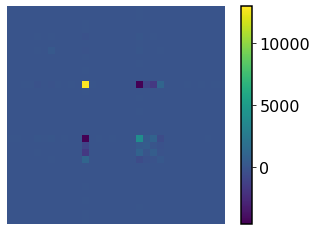

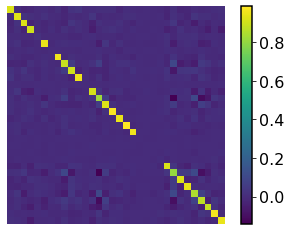

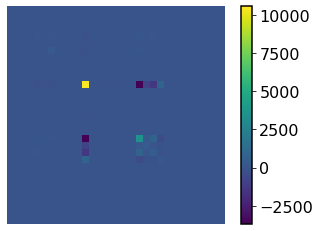

0


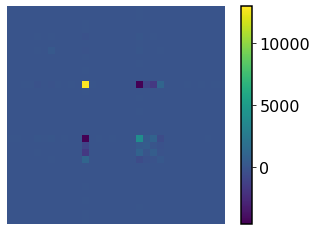

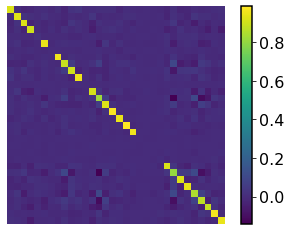

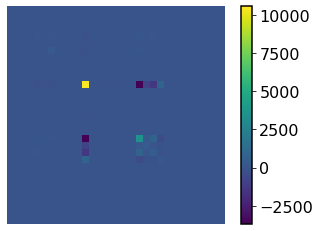

0


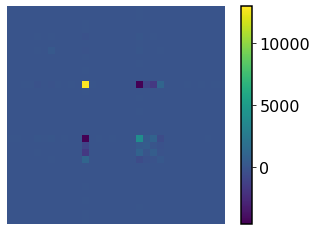

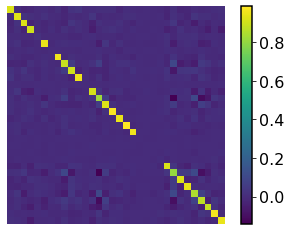

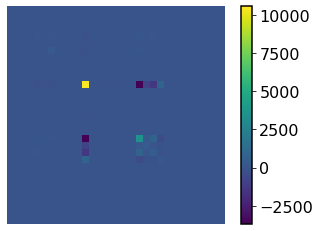

0


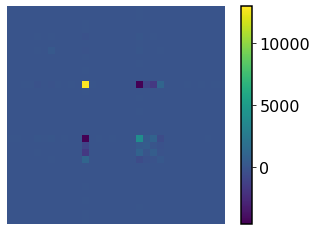

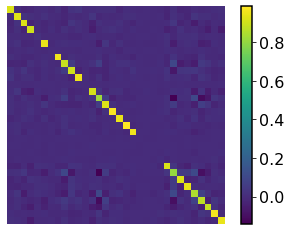

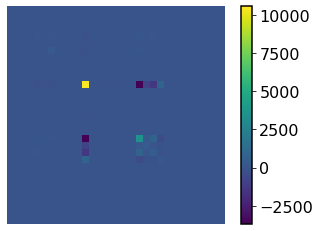

0


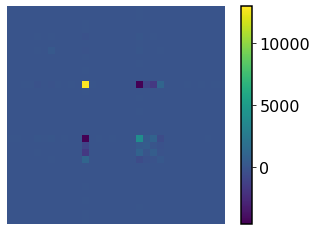

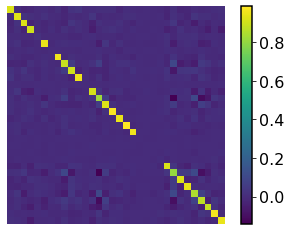

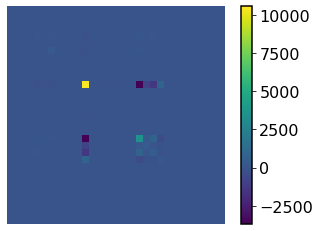

0


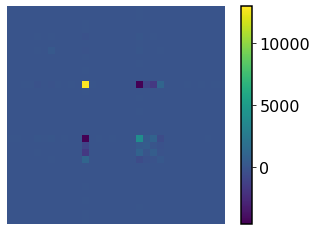

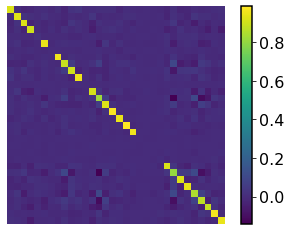

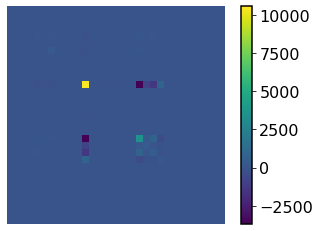

0


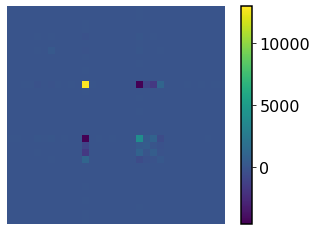

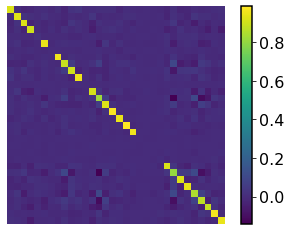

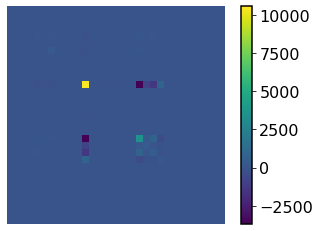

0


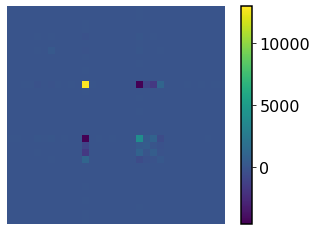

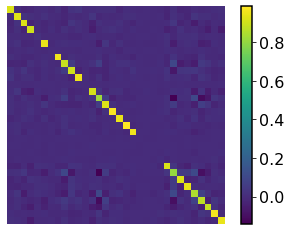

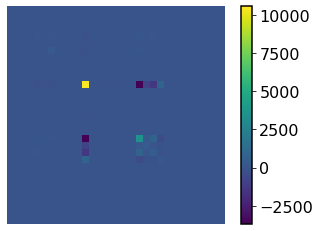

0


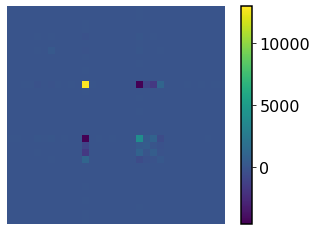

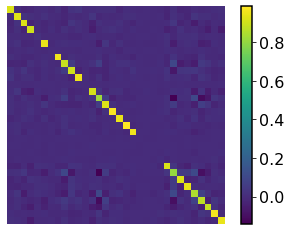

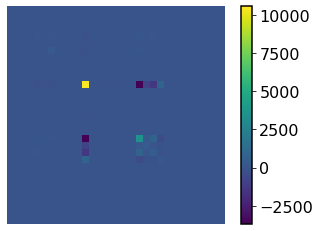

0


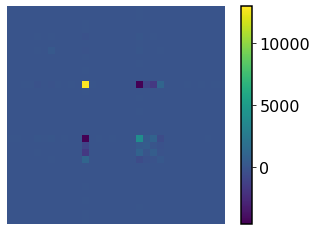

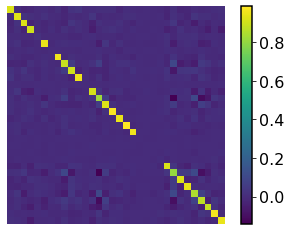

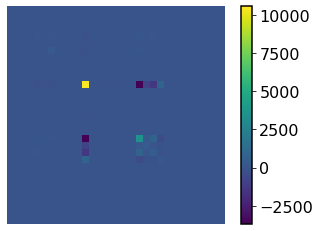

In [30]:


for ii in range(10):
    ii=0
    print(ii)
    H   = -h[ii,:,ii,:]
    cov = np.linalg.inv(H)
    np.linalg.cholesky(H)
    plt.imshow(H)
    plt.colorbar()
    plt.axis('off')
    plt.savefig(os.path.join(PLOT_PATH,'xtest_image%d_Hessian_VAE.pdf'%ii))
    plt.show()
    
    plt.imshow(cov)
    plt.colorbar()
    plt.axis('off')
    plt.savefig(os.path.join(PLOT_PATH,'xtest_image%d_cov_VAE.pdf'%ii), bbox_inches='tight')
    plt.show()
    
    plt.imshow(GNs[ii])
    plt.colorbar()
    plt.axis('off')
    plt.savefig(os.path.join(PLOT_PATH,'xtest_image%d_GN_VAE.pdf'%ii), bbox_inches='tight')
    plt.show()
    



### Sampling

##### load samples or sample below

In [28]:
burnin     = 300
ntreelevel = 8
samples    = np.load(os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/VAE/samples','NUTS_FMNIST_latent_dim%d_burnin%d_ntreelevel%d_1batch2000.npy'%(params['latent_size'], burnin, ntreelevel)))

In [31]:
import time

In [32]:
initial_step_size = np.ones((params['batch_size'],params['latent_size']))*0.02

In [33]:
# Initialize the HMC transition kernel.
num_results = int(50)
print(num_results)

def get_kernel(ii,num_burnin_steps, ntreelevel):
    x     = x_test[ii*params['batch_size']:(ii+1)*params['batch_size']]
    LP    = LogP(x)
    z_ini = get_encoded(x)
    adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=LP.logp,max_tree_depth= ntreelevel,
            #num_leapfrog_steps=num_lp_steps,
            step_size=initial_step_size),
            num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP

# Run the chain (with burn-in).
@tf.function()
def run_chain(adapative_hmc, z_ini, num_burnin_steps):
  # Run the chain (with burn-in).
    samples, [step_size, accept_ratio, leapfrogs] = tfp.mcmc.sample_chain(
      num_results      = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state    = z_ini,
      kernel           = adaptive_hmc,
      trace_fn         = lambda _, pkr: [pkr.inner_results.step_size,
                             pkr.inner_results.is_accepted, pkr.inner_results.leapfrogs_taken])

    return samples, step_size, accept_ratio, leapfrogs

50


In [ ]:
begin = time.time()
for ii in range(0,1):
    print(ii)
    for jj, burnin in enumerate([10,20,50,100,150,200]):
        for nn,  ntreelevel in enumerate([5,6,7,8]):
            samples_ = []
            adaptive_hmc, z_ini, LP= get_kernel(ii,burnin, ntreelevel)
            samples, step_size, accept_ratio, leapfrogs = run_chain(adaptive_hmc, tf.convert_to_tensor(z_ini),tf.constant(burnin))
            end = time.time()-begin
            print(end)
            begin = time.time()
            samples_.append(samples)
            print(samples.shape)
            samples = np.swapaxes(np.asarray(samples_),1,2)
            print(samples.shape)
            samples = np.reshape(samples,(-1,num_results,params['latent_size']))
            print(samples.shape)
            filename= os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/VAE/samples','NUTS_FMNIST_latent_dim%d_burnin%d_ntreelevel%d_1batch%d.npy'%(params['latent_size'], burnin, ntreelevel, num_results))
            np.save(filename,samples)


In [29]:
mean = samples[0].mean(axis=0)

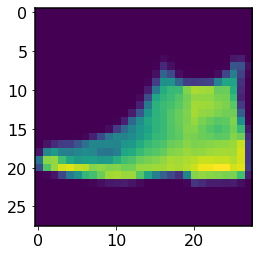

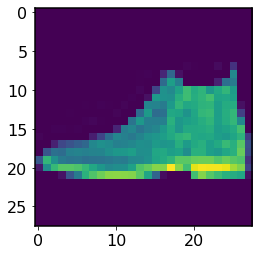

In [31]:
#plot mean of first
plt.imshow(np.squeeze(get_decoded(build_container(mean))[0]))
plt.show()
plt.imshow(np.squeeze(x_test[0]))

In [32]:
vae_var  = np.var(samples[0],axis=0).flatten()
vae_mean = np.mean(samples[0],axis=0).flatten()

### info gain from prior to posterior

In [38]:
def inf_gain(var,mean):
    return 1/2*sum(var+mean**2-1-np.log(var))
print(inf_gain(vae_var,vae_mean))

23.325062906369567


In [39]:
inf_gains=[]
vars_ = []
print(samples.shape)
for ii in range(len(samples)):
    var  = np.var(samples[ii],axis=0).flatten()
    vars_.append(var)
    mean = np.mean(samples[ii],axis=0).flatten()
    inf_gains.append(inf_gain(var,mean))

(128, 2000, 32)


In [41]:
np.mean(inf_gains), np.std(inf_gains)

(29.39430566822716, 12.277604187184496)

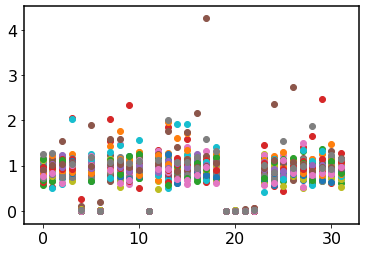

In [40]:
# inspect variances
for ii in range(len(vars_)):
    plt.scatter(np.arange(32),vars_[ii])
plt.show()

In [42]:
# imported from PAE u-space notebook
pae_var = np.array([0.09181955, 0.14972927, 0.15219298, 0.03804834, 0.19877668,
       0.2286741 , 0.10740907, 0.19130428, 0.16725737, 0.00594835,
       0.08420859, 0.01141137, 0.13337286, 0.17469847, 0.13827796,
       0.13560459, 0.19448651, 0.11219138, 0.11827705, 0.16111968,
       0.06591393, 0.16530949, 0.20237745, 0.15819022, 0.15671445,
       0.24997373, 0.0503151 , 0.03967091, 0.18444918, 0.09823425,
       0.10182273, 0.14639531], dtype=np.float32)

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


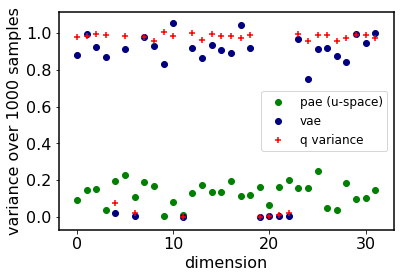

In [40]:
plt.scatter(np.arange(32),pae_var, label='pae (u-space)', color='green')
plt.scatter(np.arange(32),vae_var, label='vae',color='navy')
plt.scatter(np.arange(32),sigma_encoded**2, marker='+', color='red',label='q variance ')
plt.ylabel('variance over 1000 samples')
plt.xlabel('dimension')
plt.legend()
plt.show()

### check if sample covariance is truly diagonal

In [41]:
s0 = samples[0]

In [42]:
cov = np.dot(np.transpose((s0-s0.mean(axis=0))),s0-s0.mean(axis=0))/len(s0)

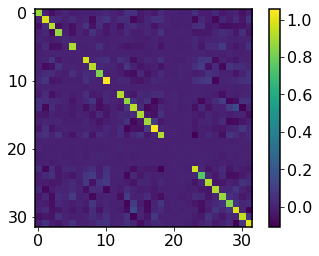

In [43]:
plt.imshow(cov)
plt.colorbar()

### plot samples

In [74]:
import corner

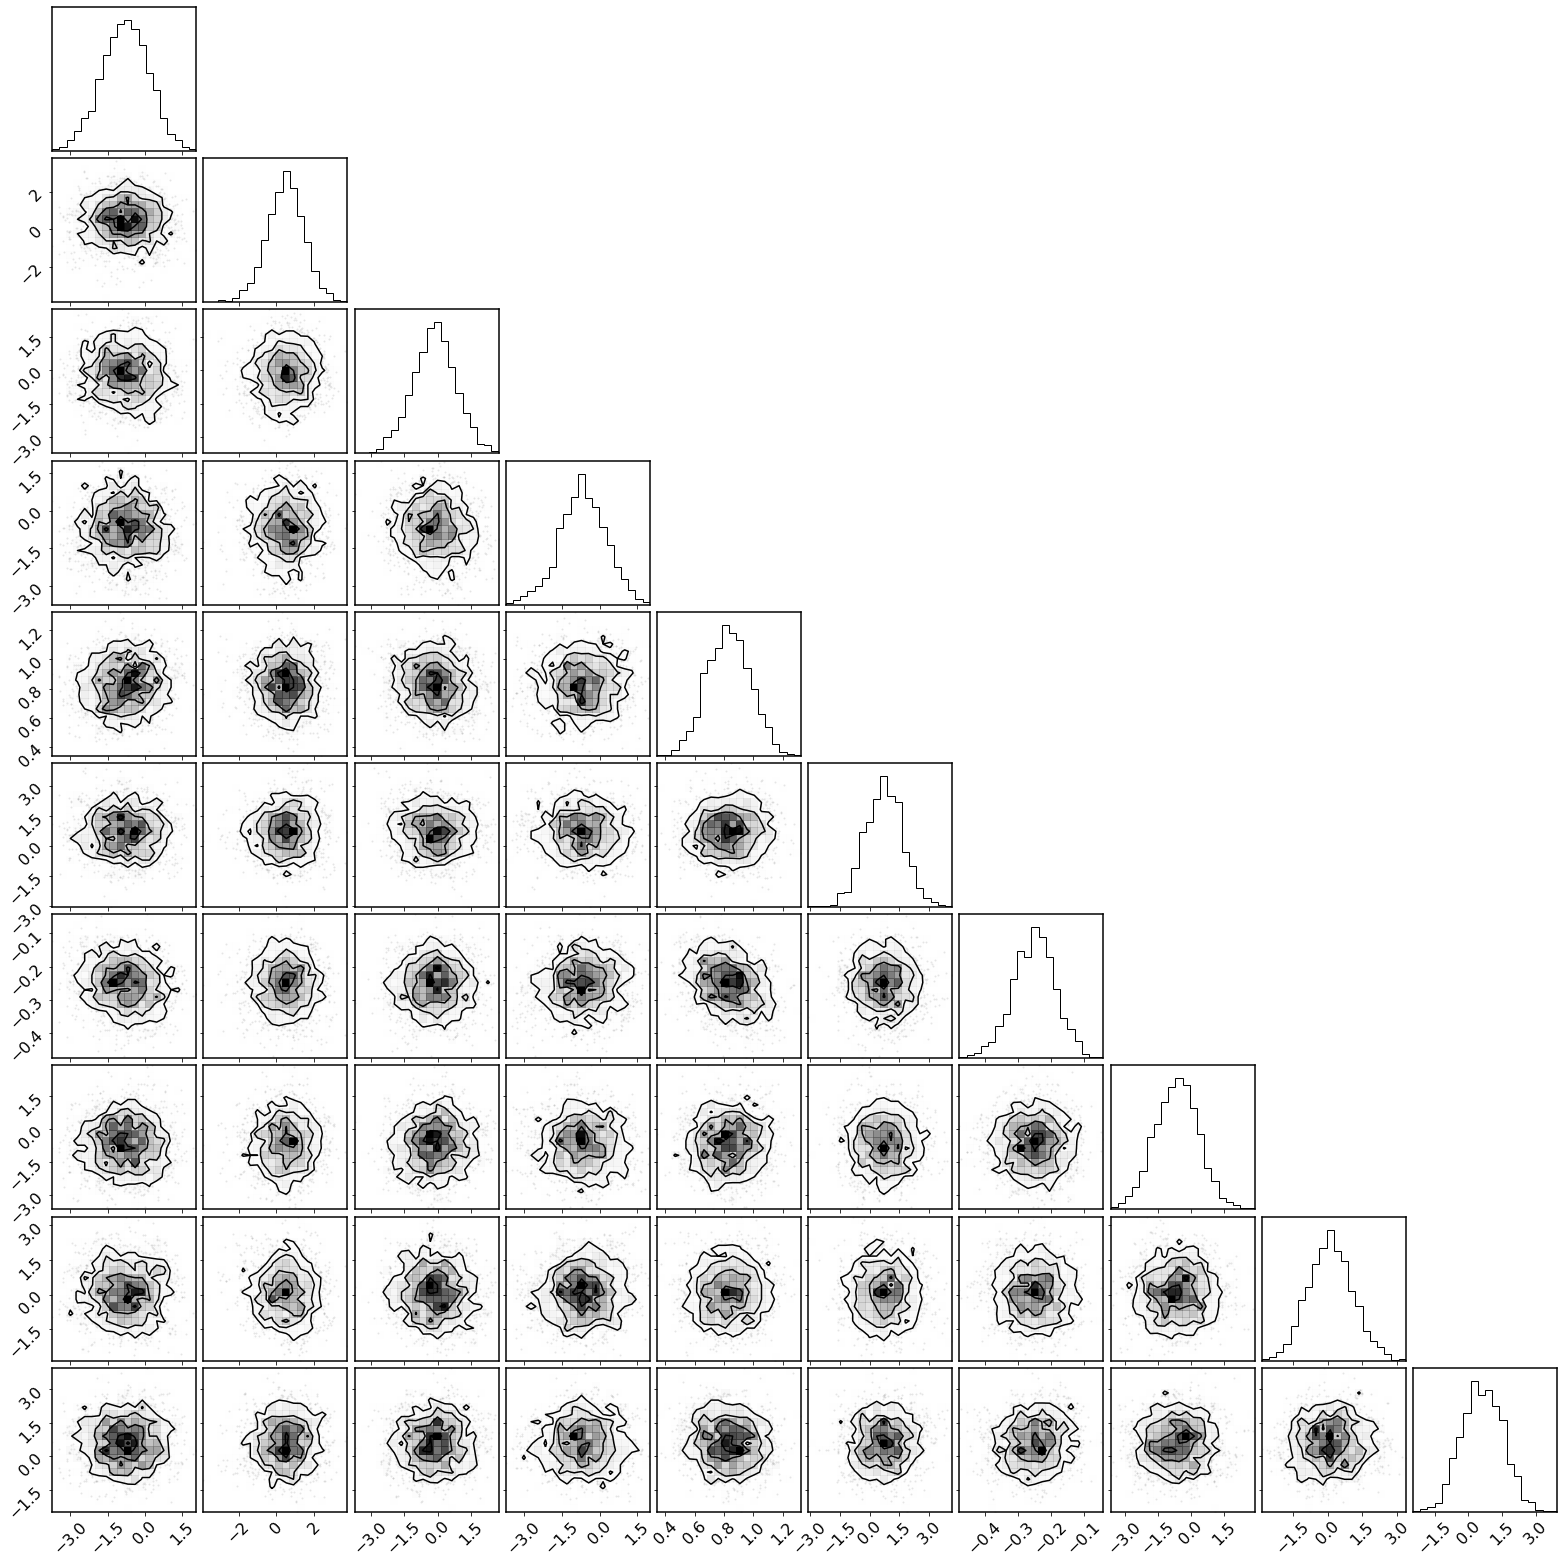

In [88]:
corner.corner(samples[0,:,0:10])
plt.show()

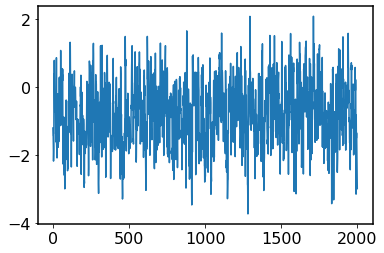

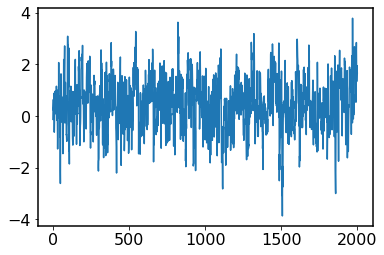

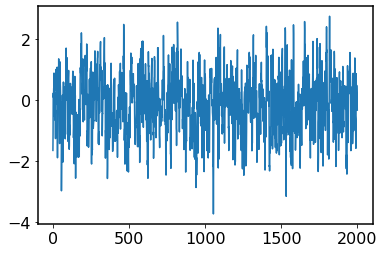

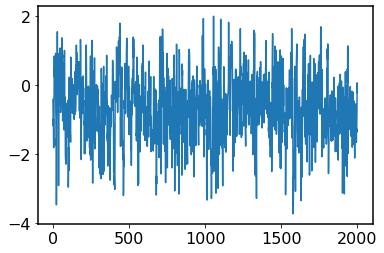

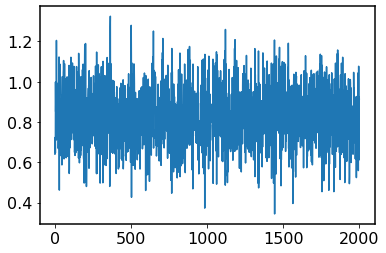

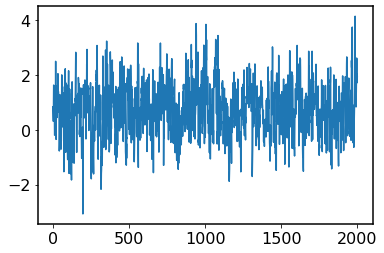

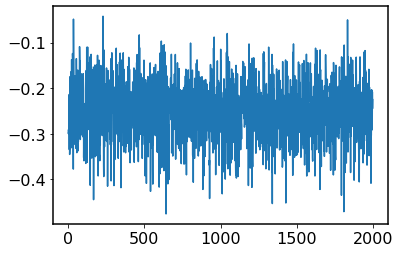

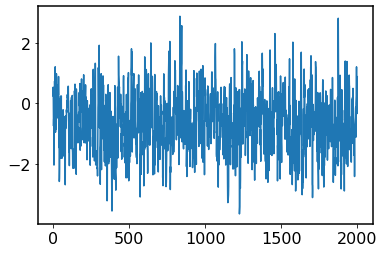

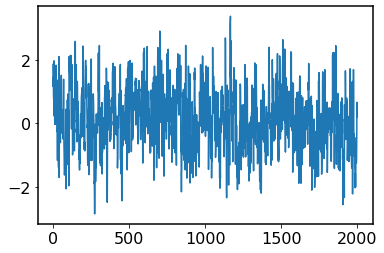

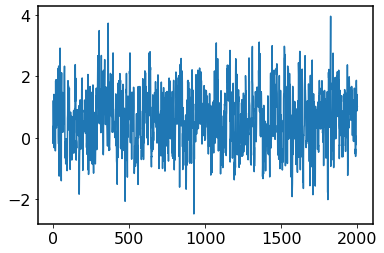

In [39]:
for ii in range(10):
    plt.plot(samples[0,:,ii])
    plt.show()

### correlation length of samples

In [40]:


def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf



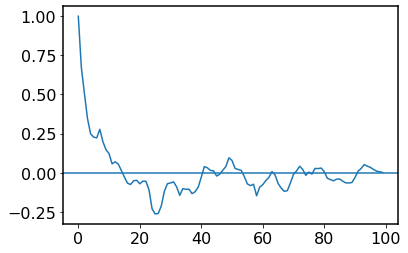

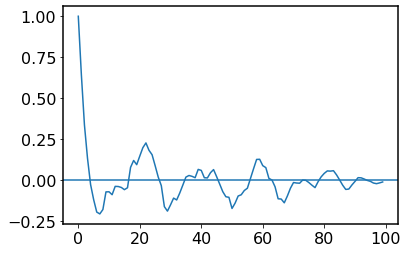

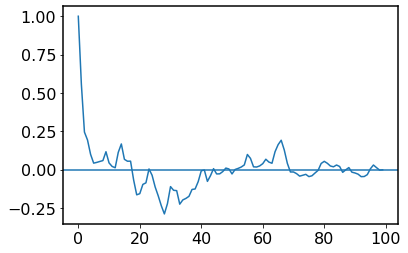

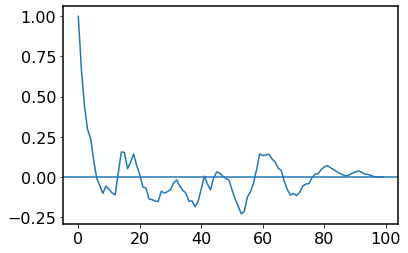

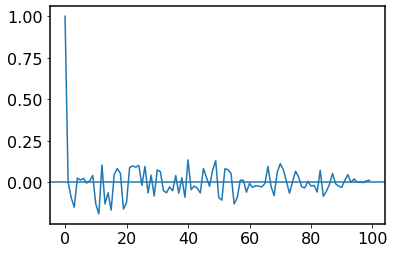

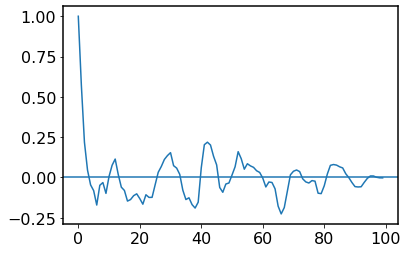

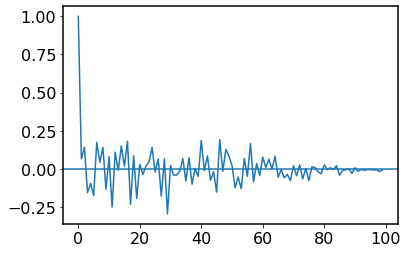

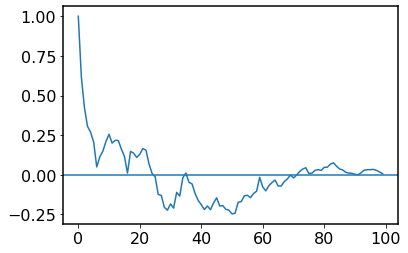

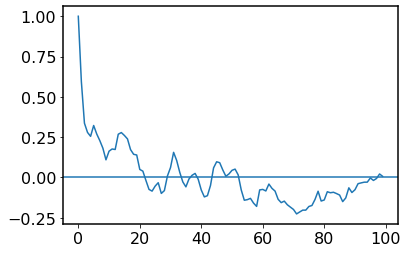

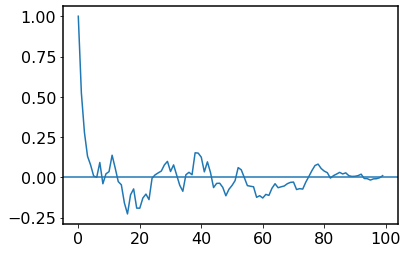

In [41]:


for ii in range(10):
    for n in [100]:
        acf = autocorr_func_1d(samples[0,:n,ii], norm=True)
        plt.plot(acf)
        plt.axhline(0)
        plt.show()

